<a href="https://colab.research.google.com/github/hariPrasadCoder/AAVE-price-prediction-using-ARIMA/blob/main/AAVE_Price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AAVE PRICE FORECASTING USING ARIMA MODEL:

## Importing necessary basic libraries:

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import mean_squared_error
from math import sqrt

## Reading the dataset:

In [5]:
df = pd.read_csv('Aave Historical Data - Investing.com.csv')
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,"Feb 13, 2022",158.20,162.15,165.21,155.82,48.69K,-2.41%
1,"Feb 12, 2022",162.11,163.43,168.59,160.18,72.76K,-0.77%
2,"Feb 11, 2022",163.37,175.38,181.02,160.46,100.78K,-6.85%
3,"Feb 10, 2022",175.38,187.88,188.80,175.08,129.26K,-6.66%
4,"Feb 09, 2022",187.88,183.73,190.58,176.38,107.50K,2.27%


## Considering only the "date" and "Price" features for further steps:

In [6]:
df = df[['Date','Price']]
df.head()

,Date,Price
0,"Feb 13, 2022",158.20
1,"Feb 12, 2022",162.11
2,"Feb 11, 2022",163.37
3,"Feb 10, 2022",175.38
4,"Feb 09, 2022",187.88


In [7]:
df['Date'] = pd.to_datetime(df['Date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466 entries, 0 to 465
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    466 non-null    datetime64[ns]
 1   Price   466 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 7.4 KB


In [8]:
df = df.sort_values(by=['Date'])

## Setting the "date" column as an index:

In [9]:
df = df.set_index('Date')

In [10]:
df.head()

,Price
Date,
2020-11-05,30.84
2020-11-06,38.71
2020-11-07,44.41
2020-11-08,53.72
2020-11-09,55.32


## Converting DataFrame to Series:

In [11]:
df = df.squeeze()
df

Date
2020-11-05     30.84
2020-11-06     38.71
2020-11-07     44.41
2020-11-08     53.72
2020-11-09     55.32
               ...  
2022-02-09    187.88
2022-02-10    175.38
2022-02-11    163.37
2022-02-12    162.11
2022-02-13    158.20
Name: Price, Length: 466, dtype: float64

## Splitting the dataset to train and validation, and saving it as separate csv files:

In [13]:
split_point = len(df) - 5
dataset, validation = df[0:split_point], df[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
dataset.to_csv('aave_dataset_final.csv', header=False)
validation.to_csv('aave_validation.csv', header=False)

Dataset 461, Validation 5


## Fitting the model using a baseline model called "Persistence model":

In [14]:
# evaluate a persistence model
series = pd.read_csv('aave_dataset_final.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
  # predict
  yhat = history[-1]
  predictions.append(yhat)
  # observation
  obs = test[i]
  history.append(obs)
  print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

>Predicted=205.900, Expected=207.880
>Predicted=207.880, Expected=211.300
>Predicted=211.300, Expected=187.100
>Predicted=187.100, Expected=186.960
>Predicted=186.960, Expected=203.040
>Predicted=203.040, Expected=226.520
>Predicted=226.520, Expected=236.610
>Predicted=236.610, Expected=250.530
>Predicted=250.530, Expected=230.820
>Predicted=230.820, Expected=234.230
>Predicted=234.230, Expected=261.150
>Predicted=261.150, Expected=277.090
>Predicted=277.090, Expected=308.630
>Predicted=308.630, Expected=316.740
>Predicted=316.740, Expected=314.940
>Predicted=314.940, Expected=293.120
>Predicted=293.120, Expected=303.230
>Predicted=303.230, Expected=294.580
>Predicted=294.580, Expected=304.490
>Predicted=304.490, Expected=297.100
>Predicted=297.100, Expected=271.190
>Predicted=271.190, Expected=279.420
>Predicted=279.420, Expected=271.850
>Predicted=271.850, Expected=253.670
>Predicted=253.670, Expected=252.690
>Predicted=252.690, Expected=254.140
>Predicted=254.140, Expected=238.220
>

We got a RMSE value of 15.816 using the baseline model. So, our other models must be definitely better than this.

In [15]:
series.describe()

count    461.000000
mean     282.968503
std      120.185500
min       30.840000
25%      198.810000
50%      301.690000
75%      370.010000
max      629.380000
Name: 1, dtype: float64

## Visualizing our data:

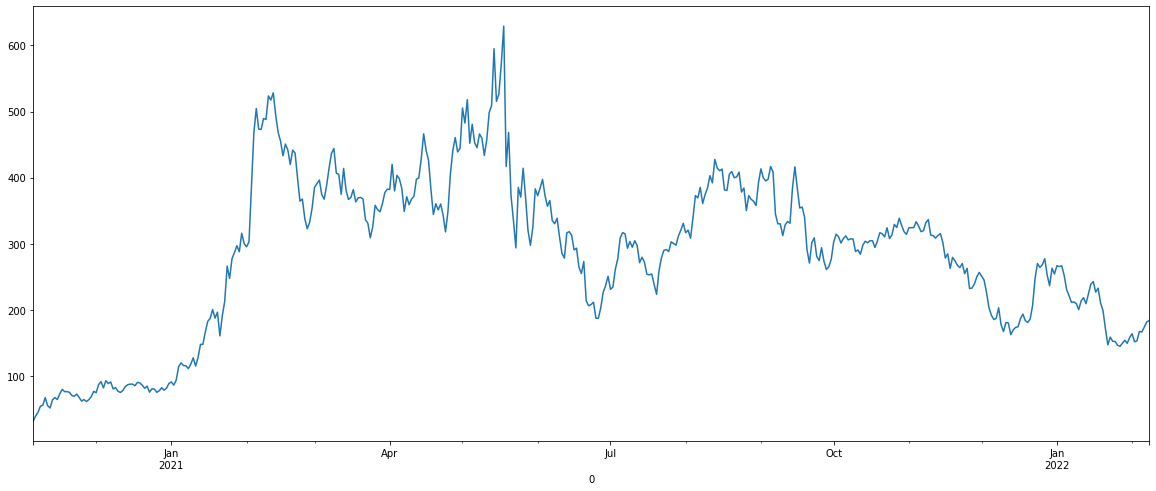

In [16]:
plt.figure(figsize=(20,8))
series.plot()

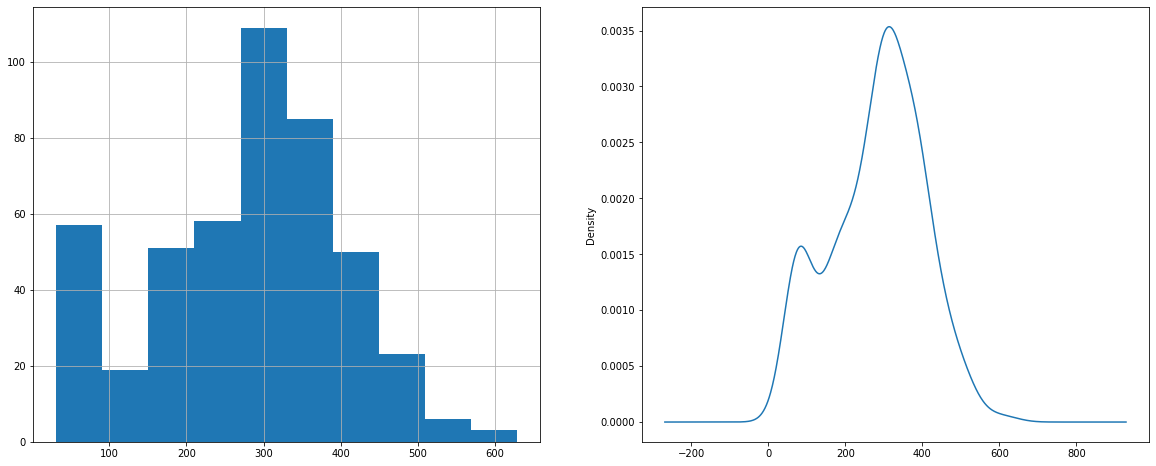

In [17]:
plt.figure(figsize=(20,8))
plt.figure(1)
plt.subplot(121)
series.hist()
plt.subplot(122)
series.plot(kind='kde')

## ADF test:

In [19]:
from statsmodels.tsa.stattools import adfuller

def difference(dataset):
  diff = list()
  for i in range(1, len(dataset)):
    value = dataset[i] - dataset[i - 1]
    diff.append(value)
  return pd.Series(diff)

# difference data
stationary = difference(X)
stationary.index = series.index[1:]
# check if stationary
result = adfuller(stationary)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
  print('\t%s: %.3f' % (key, value))
# save
stationary.to_csv('stationary.csv', header=False)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


ADF Statistic: -8.792859
p-value: 0.000000
Critical Values:
	1%: -3.445
	5%: -2.868
	10%: -2.570


ADF (Augmented Dicky Fuller) statistic is -8.79 which is less than 1% critical value. So, we can reject the null hypothesis and accept the alternate hypothesis (which is the data is stationary, by performing 1 differencing)

## Plotting Autocorrelation and Partial Autocorrelation plots:

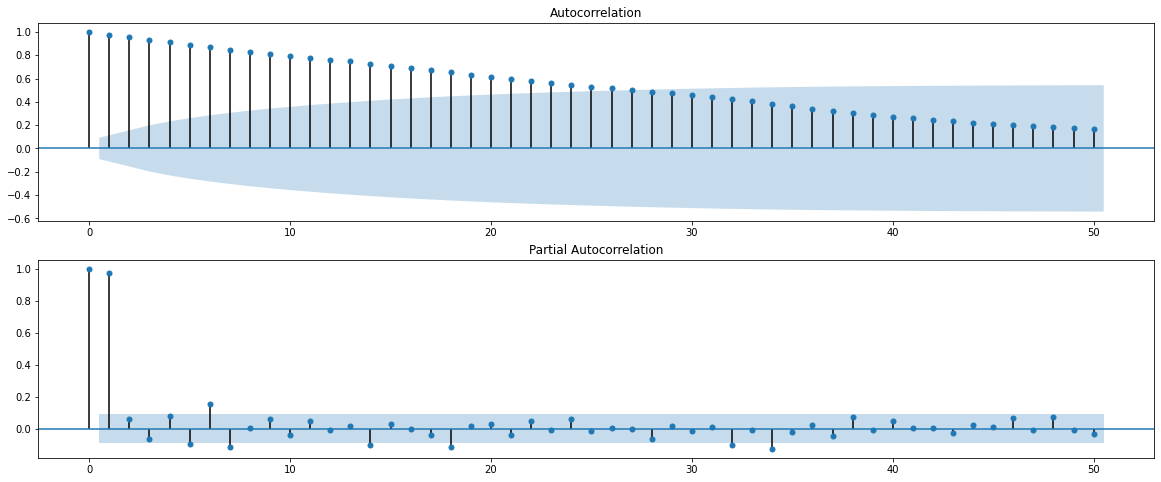

In [20]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

plt.figure(figsize=(20,8))
plt.subplot(211)
plot_acf(series, lags=50, ax=plt.gca())
plt.subplot(212)
plot_pacf(series, lags=50, ax=plt.gca())
plt.show()

## Fitting the ARIMA model using (p,d,q) = (2,1,1):

In [21]:
from statsmodels.tsa.arima_model import ARIMA
#prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)): 
  # predict
  model = ARIMA(history, order=(2,1,1))
  model_fit = model.fit(disp=0)
  yhat = model_fit.forecast()[0]
  predictions.append(yhat)
  # observation
  obs = test[i]
  history.append(obs)
  print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

>Predicted=199.940, Expected=207.880
>Predicted=212.740, Expected=211.300
>Predicted=209.039, Expected=187.100
>Predicted=191.959, Expected=186.960
>Predicted=182.997, Expected=203.040
>Predicted=205.879, Expected=226.520
>Predicted=225.245, Expected=236.610
>Predicted=239.912, Expected=250.530
>Predicted=249.461, Expected=230.820
>Predicted=235.459, Expected=234.230
>Predicted=230.731, Expected=261.150
>Predicted=263.539, Expected=277.090
>Predicted=277.839, Expected=308.630
>Predicted=309.021, Expected=316.740
>Predicted=320.265, Expected=314.940
>Predicted=315.140, Expected=293.120
>Predicted=296.127, Expected=303.230
>Predicted=300.634, Expected=294.580
>Predicted=299.608, Expected=304.490
>Predicted=301.449, Expected=297.100
>Predicted=302.349, Expected=271.190
>Predicted=270.302, Expected=279.420
>Predicted=279.244, Expected=271.850
>Predicted=274.741, Expected=253.670
>Predicted=253.815, Expected=252.690
>Predicted=252.819, Expected=254.140
>Predicted=255.372, Expected=238.220
>

## Hyper parameter tuning to find the best (p,d,q) values:

In [22]:
import warnings
# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
  # prepare training dataset
  X = X.astype('float32')
  train_size = int(len(X) * 0.50)
  train, test = X[0:train_size], X[train_size:]
  history = [x for x in train]
  # make predictions
  predictions = list()
  for t in range(len(test)):
    model = ARIMA(history, order=arima_order)
    model_fit = model.fit(disp=0)
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    history.append(test[t])
  # calculate out of sample error
  rmse = sqrt(mean_squared_error(test, predictions))
  return rmse

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
  dataset = dataset.astype('float32')
  best_score, best_cfg = float("inf"), None
  for p in p_values:
    for d in d_values:
      for q in q_values:
        order = (p,d,q)
        try:
          rmse = evaluate_arima_model(dataset, order)
          if rmse < best_score:
            best_score, best_cfg = rmse, order
          print('ARIMA%s RMSE=%.3f' % (order,rmse))
        except:
          continue
  print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

# evaluate parameters
p_values = range(0,5)
d_values = range(0,2)
q_values = range(0,3)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=71.126
ARIMA(0, 0, 1) RMSE=41.057
ARIMA(0, 0, 2) RMSE=28.260
ARIMA(0, 1, 0) RMSE=15.853
ARIMA(0, 1, 1) RMSE=16.040
ARIMA(0, 1, 2) RMSE=16.161
ARIMA(1, 0, 0) RMSE=15.770
ARIMA(1, 0, 1) RMSE=15.949
ARIMA(1, 0, 2) RMSE=16.077
ARIMA(1, 1, 0) RMSE=16.087
ARIMA(1, 1, 1) RMSE=16.244
ARIMA(2, 0, 0) RMSE=15.996
ARIMA(2, 0, 1) RMSE=16.161
ARIMA(2, 0, 2) RMSE=16.131
ARIMA(2, 1, 0) RMSE=16.241
ARIMA(2, 1, 1) RMSE=16.233
ARIMA(3, 0, 0) RMSE=16.155
ARIMA(3, 0, 1) RMSE=16.140
ARIMA(3, 1, 0) RMSE=16.314
ARIMA(3, 1, 1) RMSE=16.151
ARIMA(4, 0, 0) RMSE=16.232
ARIMA(4, 0, 1) RMSE=16.073
ARIMA(4, 1, 0) RMSE=16.234
ARIMA(4, 1, 1) RMSE=16.077
Best ARIMA(1, 0, 0) RMSE=15.770


ARIMA(1,0,0) gives us the better RMSE value. So, let's take that for further steps.

## Train the ARIMA model using (1,0,0) and analysing the residual errors that we got:

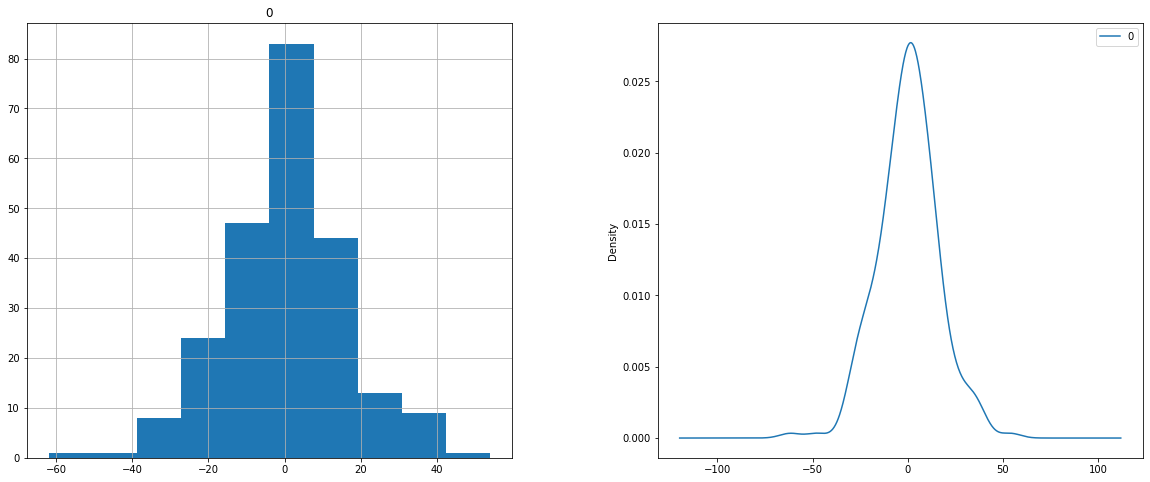

In [23]:
import warnings
warnings.filterwarnings("ignore")
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
  # predict
  model = ARIMA(history, order=(1,0,0))
  model_fit = model.fit(disp=0)
  yhat = model_fit.forecast()[0]
  predictions.append(yhat)
  # observation
  obs = test[i]
  history.append(obs)
# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = pd.DataFrame(residuals)

plt.figure(figsize=(20,8))
plt.subplot(121)
residuals.hist(ax=plt.gca())
plt.subplot(122)
residuals.plot(kind='kde', ax=plt.gca())
plt.show()

The mean of the residual errors stays at "0". So, there is no necessary in addition or subraction of bias.

## ACF and PACF of residual errors:

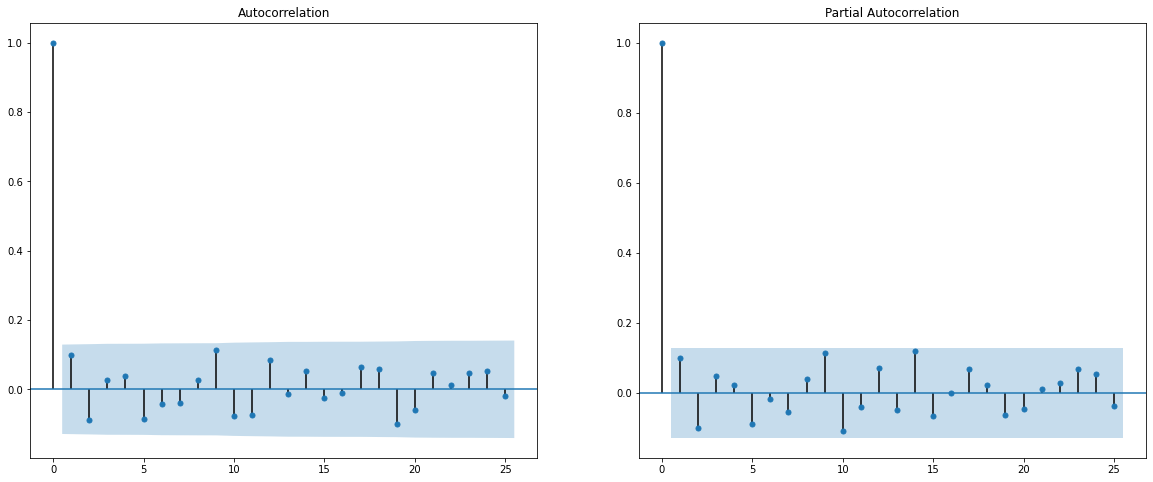

In [24]:
plt.figure(figsize=(20,8))
plt.subplot(121)
plot_acf(residuals, lags=25, ax=plt.gca())
plt.subplot(122)
plot_pacf(residuals, lags=25, ax=plt.gca())
plt.show()

## Transforming the dataset using boxcox and finding the best lambda value:

Lambda: 1.016903


<Figure size 432x288 with 0 Axes>

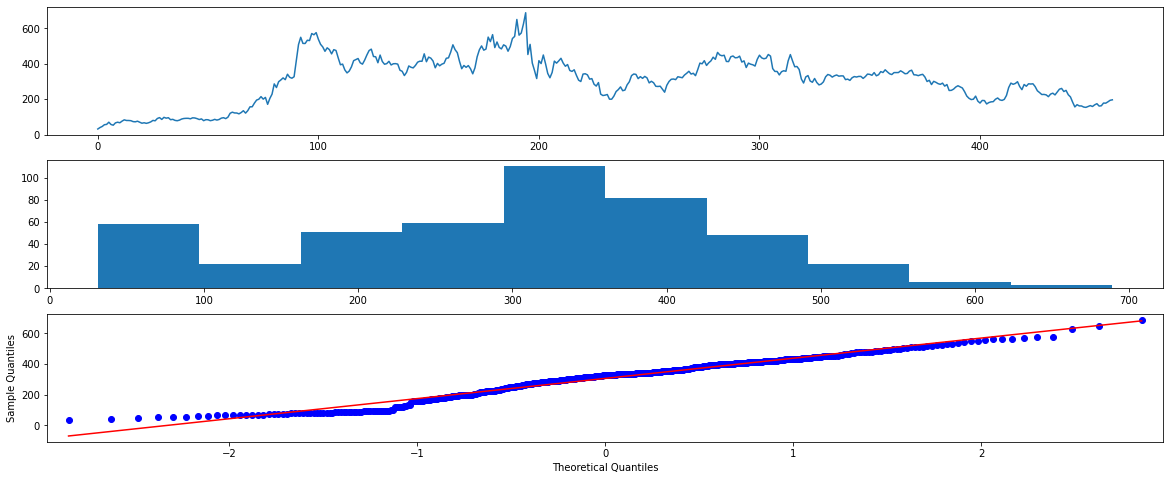

In [25]:
from scipy.stats import boxcox
from statsmodels.graphics.gofplots import qqplot
X = series.values
transformed, lam = boxcox(X)
print('Lambda: %f' % lam)
plt.figure(1)
plt.figure(figsize=(20,8))
# line plot
plt.subplot(311)
plt.plot(transformed)
# histogram
plt.subplot(312)
plt.hist(transformed)
# q-q plot
plt.subplot(313)
qqplot(transformed, line='r', ax=plt.gca())
plt.show()

Best lambda value = 1.0169

## Creating a function to inverse the tranformation that was made:

In [26]:
from math import log
from math import exp
# invert box-cox transform
def boxcox_inverse(value, lam):
  if lam == 0:
    return exp(value)
  return exp(log(lam * value + 1) / lam)

## Training the ARIMA model with the transformed data as an input:

In [27]:
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
  # transform
  transformed, lam = boxcox(history)
  if lam < -5:
    transformed, lam = history, 1
  # predict
  model = ARIMA(transformed, order=(1,0,0))
  model_fit = model.fit(disp=0)
  yhat = model_fit.forecast()[0]
  # invert transformed prediction
  yhat = boxcox_inverse(yhat, lam)
  predictions.append(yhat)
  # observation
  obs = test[i]
  history.append(obs)
  print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

>Predicted=205.941, Expected=207.880
>Predicted=207.893, Expected=211.300
>Predicted=211.274, Expected=187.100
>Predicted=187.310, Expected=186.960
>Predicted=187.161, Expected=203.040
>Predicted=203.076, Expected=226.520
>Predicted=226.313, Expected=236.610
>Predicted=236.295, Expected=250.530
>Predicted=250.068, Expected=230.820
>Predicted=230.569, Expected=234.230
>Predicted=233.943, Expected=261.150
>Predicted=260.573, Expected=277.090
>Predicted=276.341, Expected=308.630
>Predicted=307.535, Expected=316.740
>Predicted=315.561, Expected=314.940
>Predicted=313.785, Expected=293.120
>Predicted=292.210, Expected=303.230
>Predicted=302.210, Expected=294.580
>Predicted=293.662, Expected=304.490
>Predicted=303.463, Expected=297.100
>Predicted=296.162, Expected=271.190
>Predicted=270.553, Expected=279.420
>Predicted=278.690, Expected=271.850
>Predicted=271.213, Expected=253.670
>Predicted=253.247, Expected=252.690
>Predicted=252.279, Expected=254.140
>Predicted=253.714, Expected=238.220
>

## Saving the model and lambda value for further use:

In [29]:
X = series.values
X = X.astype('float32')
for i in range(len(X)):
  # transform
  transformed, lam = boxcox(X)
  if lam < -5:
    transformed, lam = X, 1
# fit model
model = ARIMA(transformed, order=(1,0,0))
model_fit = model.fit(disp=0)
# save model
model_fit.save('model.pkl')
np.save('model_lambda.npy', [lam])

## Loading the saved model and forecasted the next output:

In [30]:
from statsmodels.tsa.arima_model import ARIMAResults

model_fit = ARIMAResults.load('model.pkl')
lam = np.load('model_lambda.npy')
yhat = model_fit.forecast()[0]
yhat = boxcox_inverse(yhat, lam)
print('Predicted: %.3f' % yhat)

Predicted: 184.787


## Finally, checking the performance of the model by predicting the outcomes of validation data that was set aside initially:

In [32]:
dataset = pd.read_csv('aave_dataset_final.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
X = dataset.values.astype('float32')
history = [x for x in X]
validation = pd.read_csv('aave_validation.csv', header=None, index_col=0, parse_dates=True,
squeeze=True)
y = validation.values.astype('float32')
# load model
model_fit = ARIMAResults.load('model.pkl')
lam = np.load('model_lambda.npy')
# make first prediction
predictions = list()
yhat = model_fit.forecast()[0]
yhat = boxcox_inverse(yhat, lam)
predictions.append(yhat)
history.append(y[0])
print('>Predicted=%.3f, Expected=%.3f' % (yhat, y[0]))
# rolling forecasts
for i in range(1, len(y)):
  # transform
  transformed, lam = boxcox(history)
  if lam < -5:
    transformed, lam = history, 1
  # predict
  model = ARIMA(transformed, order=(1,0,0))
  model_fit = model.fit(disp=0)
  yhat = model_fit.forecast()[0]
  # invert transformed prediction
  yhat = boxcox_inverse(yhat, lam)
  predictions.append(yhat)
  # observation
  obs = y[i]
  history.append(obs)
  print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(y, predictions))
print('RMSE: %.3f' % rmse)

>Predicted=184.787, Expected=187.880
>Predicted=188.890, Expected=175.380
>Predicted=176.547, Expected=163.370
>Predicted=164.684, Expected=162.110
>Predicted=163.426, Expected=158.200
RMSE: 8.940


RMSE value for the validation data is 8.940

## Expected vs Predicted:

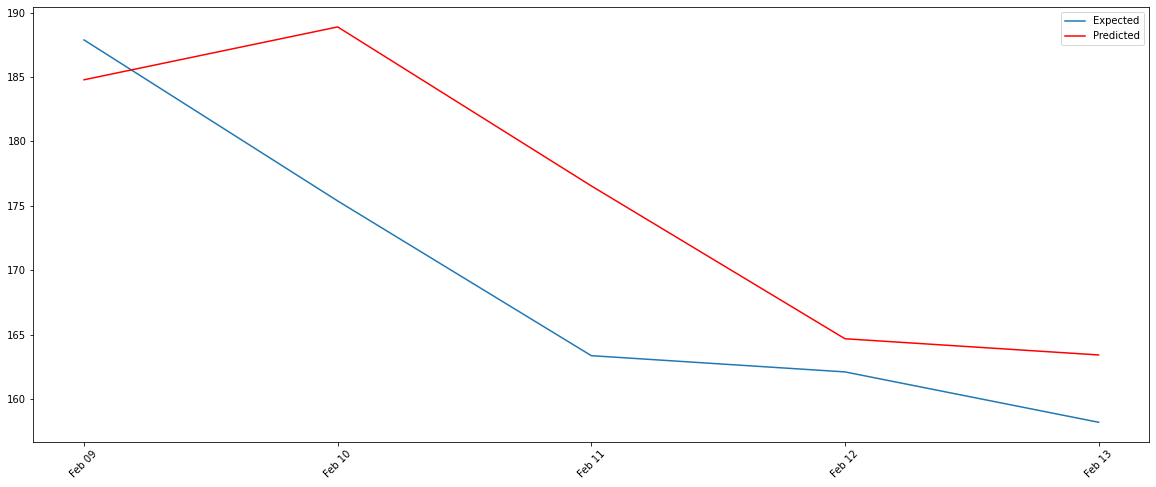

In [42]:
plt.figure(figsize=(20,8))
plt.plot(y)
plt.plot(predictions, color='red')
plt.legend(['Expected','Predicted'])


group_labels = ['Feb 10','Feb 11','Feb 12', 'Feb 13']

x1 = [0,1,2,3,4]
dates = ['Feb 09', 'Feb 10','Feb 11','Feb 12', 'Feb 13']

plt.xticks(x1, dates, rotation=45)
plt.show()